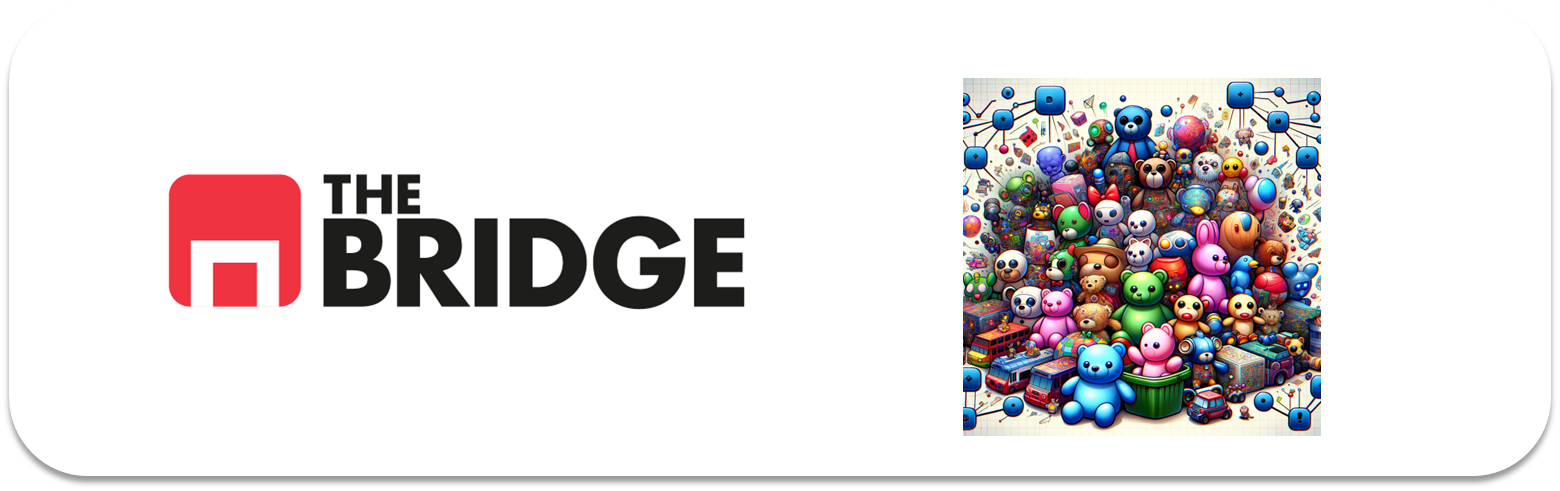

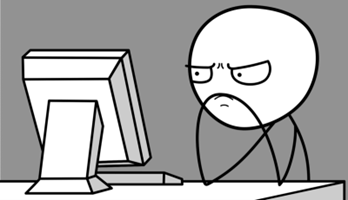

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, silhouette_samples 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FixedLocator, FixedFormatter


## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
# Cargar el conjunto de datos de Olivetti Faces
olivetti_faces = fetch_olivetti_faces()

# Mostrar la descripción del conjunto de datos
print(olivetti_faces['DESCR'])


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
olivetti_faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [4]:
# Extraer las imágenes y el target
data = olivetti_faces['data']
target = olivetti_faces['target']

# Crear un dataframe con las imágenes y añadir la columna 'target'
df_images = pd.DataFrame(data)
df_images['target'] = target

# Reordenar aleatoriamente las filas del dataframe
df_images = df_images.sample(frac=1.0, random_state=42).reset_index(drop=True)
df_images.head()


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20
1,0.185950,0.128099,0.115702,0.132231,0.185950,0.268595,0.433884,0.541322,0.570248,0.586777,...,0.396694,0.409091,0.301653,0.421488,0.462810,0.247934,0.190083,0.210744,0.210744,28
2,0.508264,0.603306,0.619835,0.628099,0.657025,0.665289,0.690083,0.727273,0.743802,0.768595,...,0.301653,0.305785,0.314050,0.326446,0.338843,0.330579,0.334711,0.342975,0.342975,3
3,0.136364,0.140496,0.185950,0.280992,0.318182,0.363636,0.409091,0.417355,0.438017,0.454545,...,0.169421,0.206612,0.276859,0.355372,0.685950,0.661157,0.280992,0.371901,0.276859,21
4,0.652893,0.644628,0.652893,0.706612,0.714876,0.719008,0.743802,0.747934,0.747934,0.756198,...,0.074380,0.074380,0.082645,0.082645,0.111570,0.070248,0.086777,0.185950,0.231405,9


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [5]:
train_set, tmp_test_set = train_test_split(df_images, test_size=0.2, stratify=df_images['target'], random_state=42)
val_set, test_set = train_test_split(tmp_test_set, test_size=0.5, stratify=tmp_test_set['target'], random_state=42)

(train_set.shape, val_set.shape, test_set.shape)

((320, 4097), (40, 4097), (40, 4097))

### #1.4

Crea los pares X,y para train, validation y test.

In [6]:
X_train = train_set.drop(columns=['target'])
X_valid = val_set.drop(columns=['target'])
X_test = test_set.drop(columns=['target'])

y_train = train_set['target']
y_valid = val_set['target']
y_test = test_set['target']

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [7]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

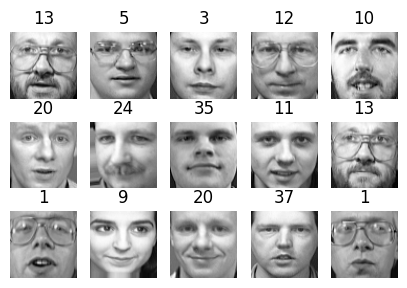

In [8]:
plot_faces(X_train.iloc[:15].to_numpy(), y_train.iloc[:15].to_numpy())

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [9]:
# 0.99=Varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

221

Hemos reducido a 221 la dimensión del problema!

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
383,0.632231,0.652893,0.582645,0.636364,0.636364,0.706612,0.747934,0.780992,0.793388,0.814050,...,0.256198,0.285124,0.272727,0.210744,0.231405,0.223140,0.107438,0.082645,0.090909,0.090909
362,0.719008,0.727273,0.723140,0.714876,0.723140,0.731405,0.739669,0.760331,0.780992,0.793388,...,0.516529,0.500000,0.438017,0.566116,0.743802,0.566116,0.314050,0.301653,0.338843,0.322314
140,0.185950,0.342975,0.512397,0.570248,0.628099,0.615702,0.652893,0.661157,0.685950,0.727273,...,0.404959,0.351240,0.326446,0.355372,0.429752,0.487603,0.371901,0.301653,0.322314,0.318182
234,0.371901,0.487603,0.566116,0.586777,0.590909,0.615702,0.657025,0.665289,0.673554,0.685950,...,0.309917,0.280992,0.297521,0.351240,0.396694,0.421488,0.438017,0.371901,0.619835,0.590909
399,0.326446,0.144628,0.260331,0.752066,0.847107,0.851240,0.847107,0.847107,0.851240,0.842975,...,0.384298,0.376033,0.334711,0.243802,0.210744,0.157025,0.181818,0.140496,0.301653,0.157025


In [11]:
pd.DataFrame(X_train_pca).head()

,0,1,2,3,4,5,6,7,8,9,...,211,212,213,214,215,216,217,218,219,220
0,0.526412,2.222133,1.068347,-1.799269,-0.718548,1.524713,1.440413,-2.113177,1.996804,-0.587921,...,0.254085,0.115943,-0.190297,0.003486,-0.163563,0.357890,-0.104739,-0.189395,-0.079520,-0.136151
1,4.355057,2.870476,-0.259204,2.451999,3.452979,-1.514480,1.363054,0.492710,-0.245763,0.741319,...,0.406229,-0.125004,-0.194349,0.031091,0.146725,0.105390,-0.090906,0.068436,-0.034213,0.112853
2,4.598104,-0.380974,-0.637657,-0.296076,-0.376387,0.982520,0.795219,-0.804199,-0.506541,0.792179,...,-0.125867,0.094669,-0.142761,-0.072480,0.173199,0.131956,0.110545,-0.220713,-0.056120,-0.053076
3,-0.847230,-0.746171,-0.085556,-0.634096,0.677842,2.146527,1.798234,-1.140534,1.234204,-0.076509,...,0.044732,0.123461,0.153585,0.044765,0.221053,-0.061758,0.151246,0.221547,-0.046966,0.076483
4,3.364857,3.805038,-2.646902,-2.462322,-1.136410,1.312296,-0.373385,-1.876073,-1.871665,0.409603,...,0.134892,0.151108,0.115123,-0.143994,0.067750,0.032174,0.036776,0.007385,-0.006928,-0.324686


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [12]:
# No. No estaban escaladas entre 0 y 1, así que lo hago aquí
minmax = MinMaxScaler()
X_train_pca_std = minmax.fit_transform(X_train_pca)
X_valid_pca_std = minmax.transform(X_valid_pca)
X_test_pca_std = minmax.transform(X_test_pca)

pd.DataFrame(X_train_pca_std).describe()

,0,1,2,3,4,5,6,7,8,9,...,211,212,213,214,215,216,217,218,219,220
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.505012,0.492654,0.476579,0.468125,0.495661,0.456632,0.559416,0.485895,0.505292,0.553995,...,0.443151,0.487874,0.430161,0.556699,0.564222,0.498009,0.494240,0.471419,0.577573,0.449081
std,0.197454,0.158750,0.196718,0.186483,0.176701,0.185179,0.205605,0.203117,0.192718,0.175504,...,0.170418,0.164537,0.170229,0.184799,0.117828,0.155842,0.160243,0.160513,0.162156,0.164588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.403634,0.395845,0.344754,0.335492,0.360370,0.302890,0.426159,0.329061,0.378938,0.421995,...,0.336329,0.378835,0.316795,0.427351,0.487830,0.399997,0.395914,0.383138,0.483418,0.335063
50%,0.529530,0.494353,0.471118,0.480475,0.487332,0.469857,0.554097,0.490355,0.516308,0.564874,...,0.450507,0.506325,0.426031,0.565127,0.561908,0.499998,0.498691,0.472457,0.571000,0.441889
75%,0.626066,0.592774,0.616952,0.594270,0.619418,0.591631,0.710166,0.631459,0.625808,0.681336,...,0.550634,0.601505,0.541670,0.682440,0.633759,0.594559,0.589473,0.570023,0.683392,0.555192
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Para los valores tras el PCA y estandarizados.

El mejor k es: 150 con un score de silueta de: 0.015542644076049328


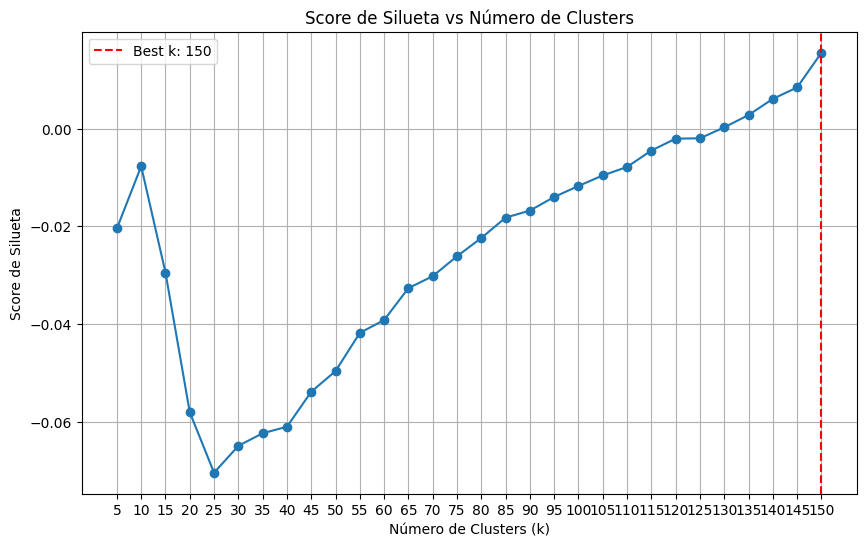

In [13]:
# Calcular el silhouette score para cada k
silhouette_scores = []
k_values = range(5, 151, 5)

# Realizar K-Means y calcular el score de silueta
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca_std)
    silhouette_scores.append(silhouette_score(X_train_pca_std, kmeans.labels_))

# Encontrar el mejor k
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"El mejor k es: {best_k} con un score de silueta de: {best_score}")

# Visualizar el score de silueta para diferentes valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Score de Silueta vs Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Score de Silueta')
plt.xticks(k_values)
plt.grid()
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k: {best_k}')
plt.legend()
plt.show()

Para los valores in estandarizar.

El mejor k es: 150 con un score de silueta de: 0.20131611824035645


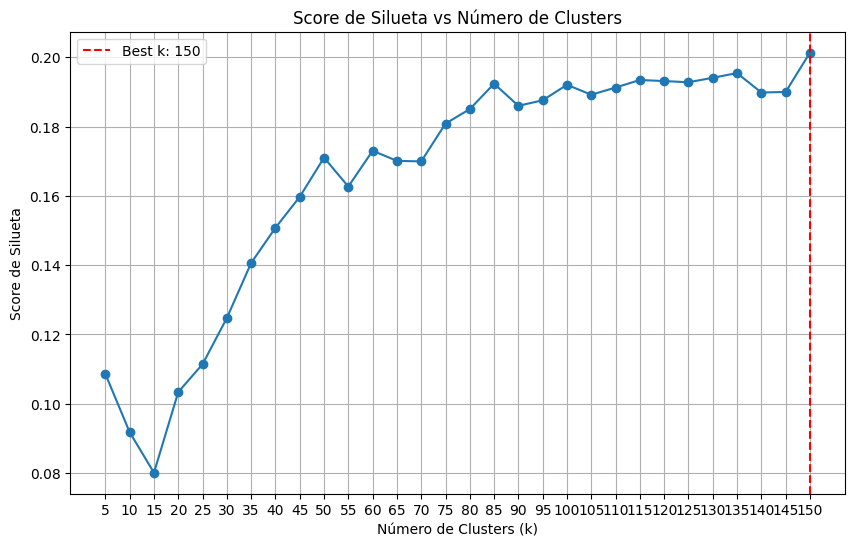

In [14]:
# Calcular el silhouette score para cada k
silhouette_scores = []
k_values = range(5, 151, 5)

# Realizar K-Means y calcular el score de silueta
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))

# Encontrar el mejor k
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"El mejor k es: {best_k} con un score de silueta de: {best_score}")

# Visualizar el score de silueta para diferentes valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Score de Silueta vs Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Score de Silueta')
plt.xticks(k_values)
plt.grid()
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k: {best_k}')
plt.legend()
plt.show()



Esto tiene un poco de trampa y es que si seguimos aumentando el número de clusters (k) hasta que iguales el número de isntancias desde luego que terminaré teniendo un score de silueta de 1, donde cada instancia pertenece a su propia clase (única) pero esto no es correcto.

Si tuviera que escoger un número de clusters sería k=10.

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

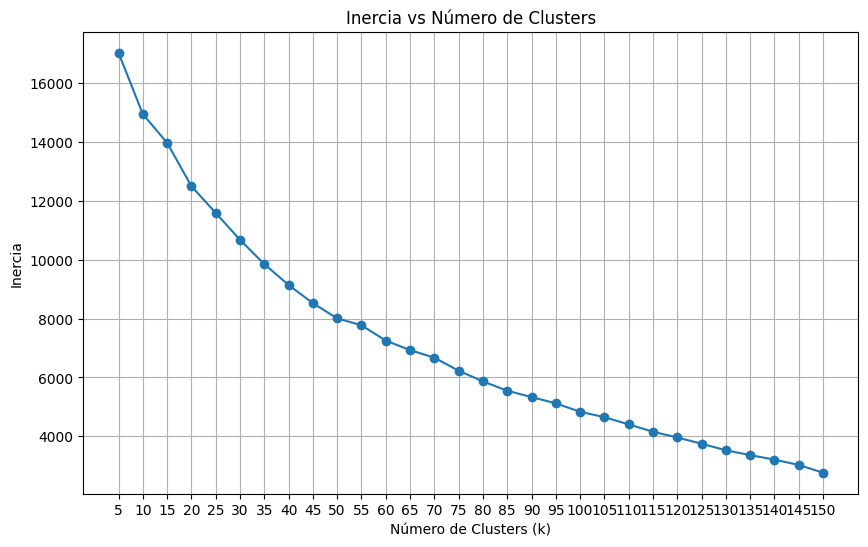

In [15]:
# Calcular el silhouette score para cada k
inertias = []
k_values = range(5, 151, 5)

# Realizar K-Means y calcular el score de silueta
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)

# DataFrame con las inercias
# df_inertias = pd.DataFrame({'k': k_values, 'inertia': inertias})
# df_inertias['diff'] = df_inertias['inertia'] - df_inertias['inertia'].shift(1)
# display(df_inertias)

# Visualizar el score de silueta para diferentes valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Inercia vs Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(k_values)
plt.grid()
plt.show()


No hay un punto de codo claro en el que la inercia comience a converger, así que me quedaría con los resultados del coeficiente de silueta.


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [16]:
k=10
best_model = KMeans(n_clusters=k, random_state=42)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Cluster 0:


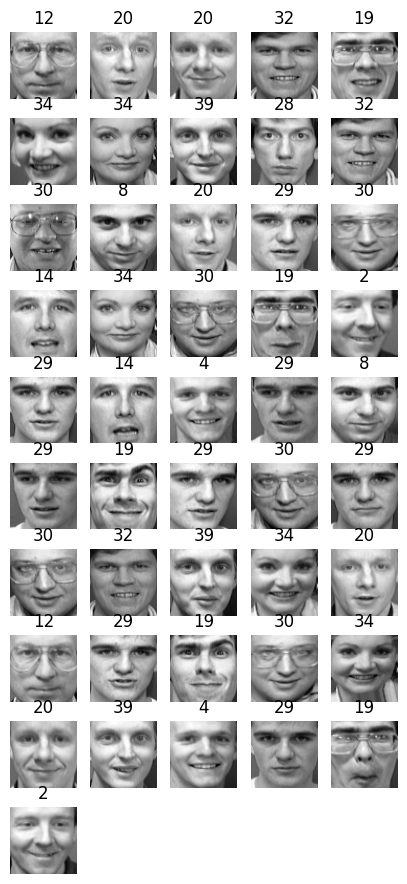

Cluster 1:


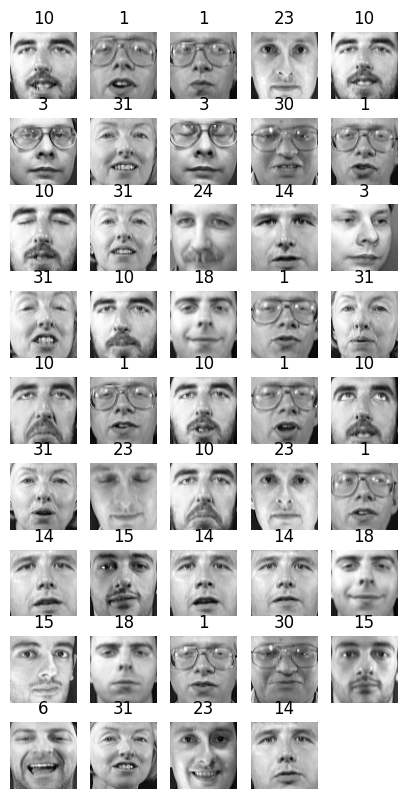

Cluster 2:


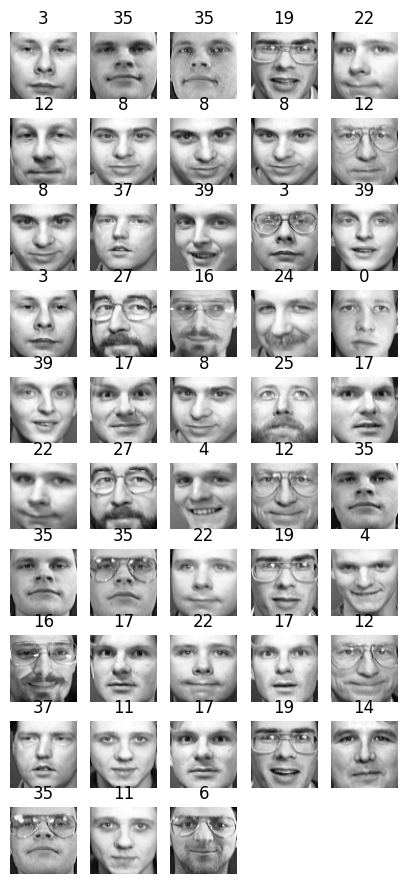

Cluster 3:


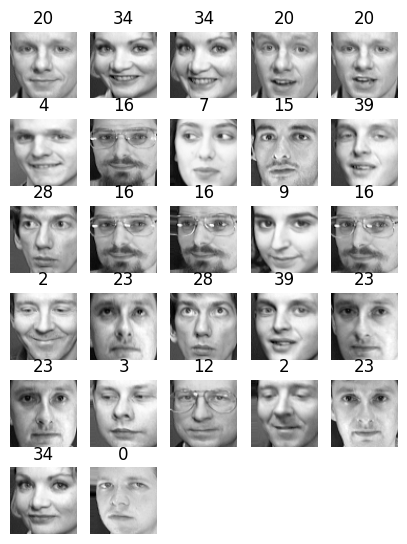

Cluster 4:


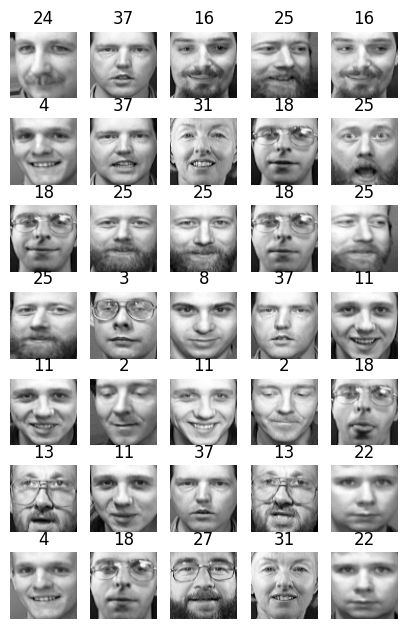

Cluster 5:


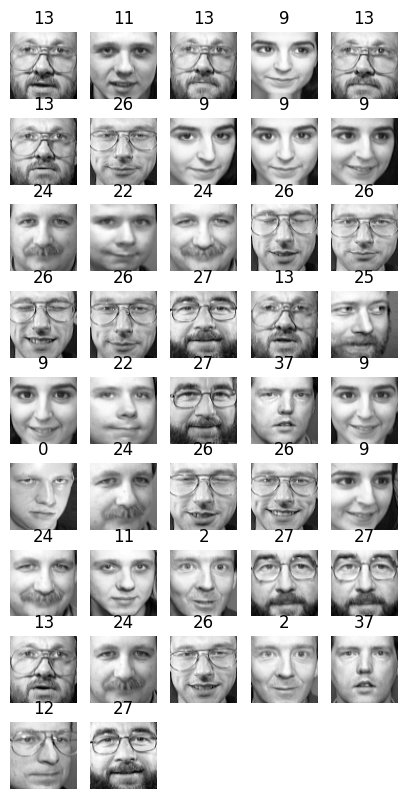

Cluster 6:


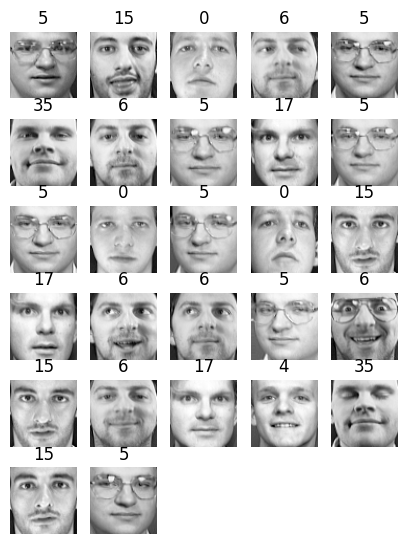

Cluster 7:


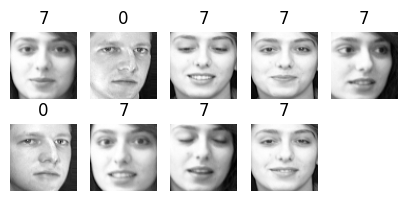

Cluster 8:


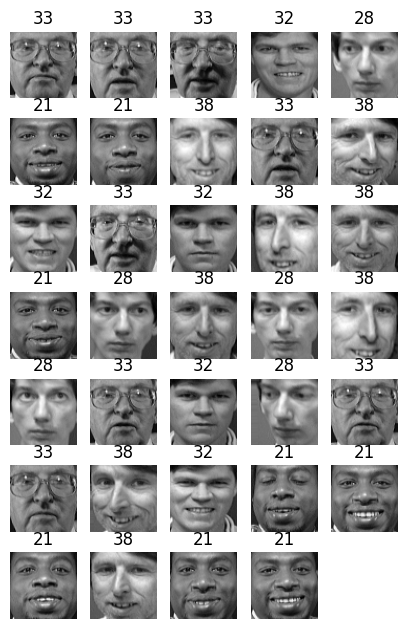

Cluster 9:


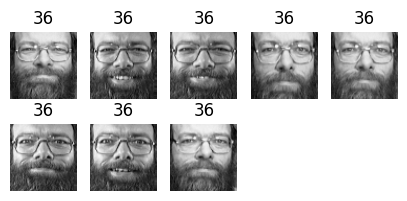

In [17]:
best_model.fit(X_train_pca)
labels = best_model.labels_

# Visualizar las caras para cada clúster
for cluster in range(k):
    print(f"Cluster {cluster}:")
    # índices de las imágenes que pertenecen al clúster específico
    indices = np.where(labels == cluster)[0]
    # Si intento pintar las caras de X_train_pca va dar error
    plot_faces(X_train.iloc[indices].to_numpy(), y_train.iloc[indices])


Sí veo algunas cara similares... pero así a ojo tampoco sabría confirmar si el clustering está bien escogido.

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [18]:

# Entrenar el clasificador RandomForest
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)
rf_classifier.fit(X_train, y_train) 

# Predecir en el conjunto de validación
y_pred = rf_classifier.predict(X_valid)

# Evaluar el modelo
accuracy = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)

# Mostrar resultados
print(f"Accuracy en el conjunto de validación: {accuracy:.2f}")
print("Reporte de clasificación:\n", report)


Accuracy en el conjunto de validación: 0.93
Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Al no limitar la profundidad de los árboles ha clasificado cada instancia como única.

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [19]:
# Transformar los conjuntos utilizando el modelo K-Means
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar el clasificador RandomForest en el conjunto reducido
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)
rf_classifier.fit(X_train_reduced, y_train.values.ravel())

# Predecir en el conjunto de validación
y_pred = rf_classifier.predict(X_valid_reduced)

# Evaluar el modelo
accuracy = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)

# Mostrar resultados
print(f"Accuracy en el conjunto de validación: {accuracy:.2f}")
print("Reporte de clasificación:\n", report)


Accuracy en el conjunto de validación: 0.57
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Vuelve a ocurrir como antes que al no limitar la profundid del árbol se aprende todas las instancias de memoria. Sin embargo, la ejecución ha sido mucho más rápida.

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [20]:
k_values = range(5, 151, 5)
best_accuracy = 0
best_k = 0

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    
    # Transformar los conjuntos utilizando el modelo K-Means
    X_train_reduced = kmeans.transform(X_train_pca)
    X_valid_reduced = kmeans.transform(X_valid_pca)
    
    # Entrenar el clasificador RandomForest en el conjunto reducido
    rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_classifier.fit(X_train_reduced, y_train)
    
    # Predecir en el conjunto de validación
    y_pred = rf_classifier.predict(X_valid_reduced)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_valid, y_pred)
    
    # Almacenar el mejor rendimiento y el valor de k correspondiente
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Mostrar el mejor rendimiento y el valor de k
print(f"El mejor valor de k es {best_k} con una precisión de {best_accuracy:.2f}")


El mejor valor de k es 40 con una precisión de 0.82


Para mi esto no tiene sentido porque el resultado es regulero para la pedazo cantidad de clusters que se han hecho.